<a href="https://colab.research.google.com/github/guilhermegranchopro/Eco-AI.ly/blob/main/Power_Breakdown/Power_Consumption_Breakdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from math import ceil

In [8]:
# Requisição à API
response = requests.get(
    "https://api.electricitymap.org/v3/power-breakdown/history?zone=PT",
    headers={"auth-token": "czG7nq1wv9OHi1phrXUn"}
)
data = response.json()

# Obtém o histórico de dados
historico = data.get("history", [])

In [9]:
def aggregate_consumption(history, time_hours, now):
    """
    Agrega os valores da chave 'powerConsumptionBreakdown' e o campo 'powerConsumptionTotal'
    para os registros que se encontram no intervalo de 'time_hours' até 'now'.

    Retorna:
      - Um dicionário com a soma dos valores para cada chave do breakdown;
      - O total agregado de 'powerConsumptionTotal';
      - O timestamp limite.
    """
    limite = now - timedelta(hours=time_hours)
    consumption_breakdown_total = {}
    consumption_total_sum = 0
    for registro in history:
        dt_str = registro.get("datetime")
        if not dt_str:
            continue
        # Converte o timestamp para um objeto datetime aware (UTC)
        dt = datetime.fromisoformat(dt_str.replace("Z", "+00:00"))
        if dt < limite or dt > now:
            continue

        cons_breakdown = registro.get("powerConsumptionBreakdown", {})
        for key, val in cons_breakdown.items():
            if val is None:
                val = 0
            consumption_breakdown_total[key] = consumption_breakdown_total.get(key, 0) + val

        # Agrega o total de consumo
        val_total = registro.get("powerConsumptionTotal", 0)
        if val_total is None:
            val_total = 0
        consumption_total_sum += val_total

    return consumption_breakdown_total, consumption_total_sum, limite

In [10]:
def format_label(label):
    """
    Formata o label: se estiver todo em maiúsculas, mantém; caso contrário, capitaliza a primeira letra.
    """
    return label if label.isupper() else label.capitalize()

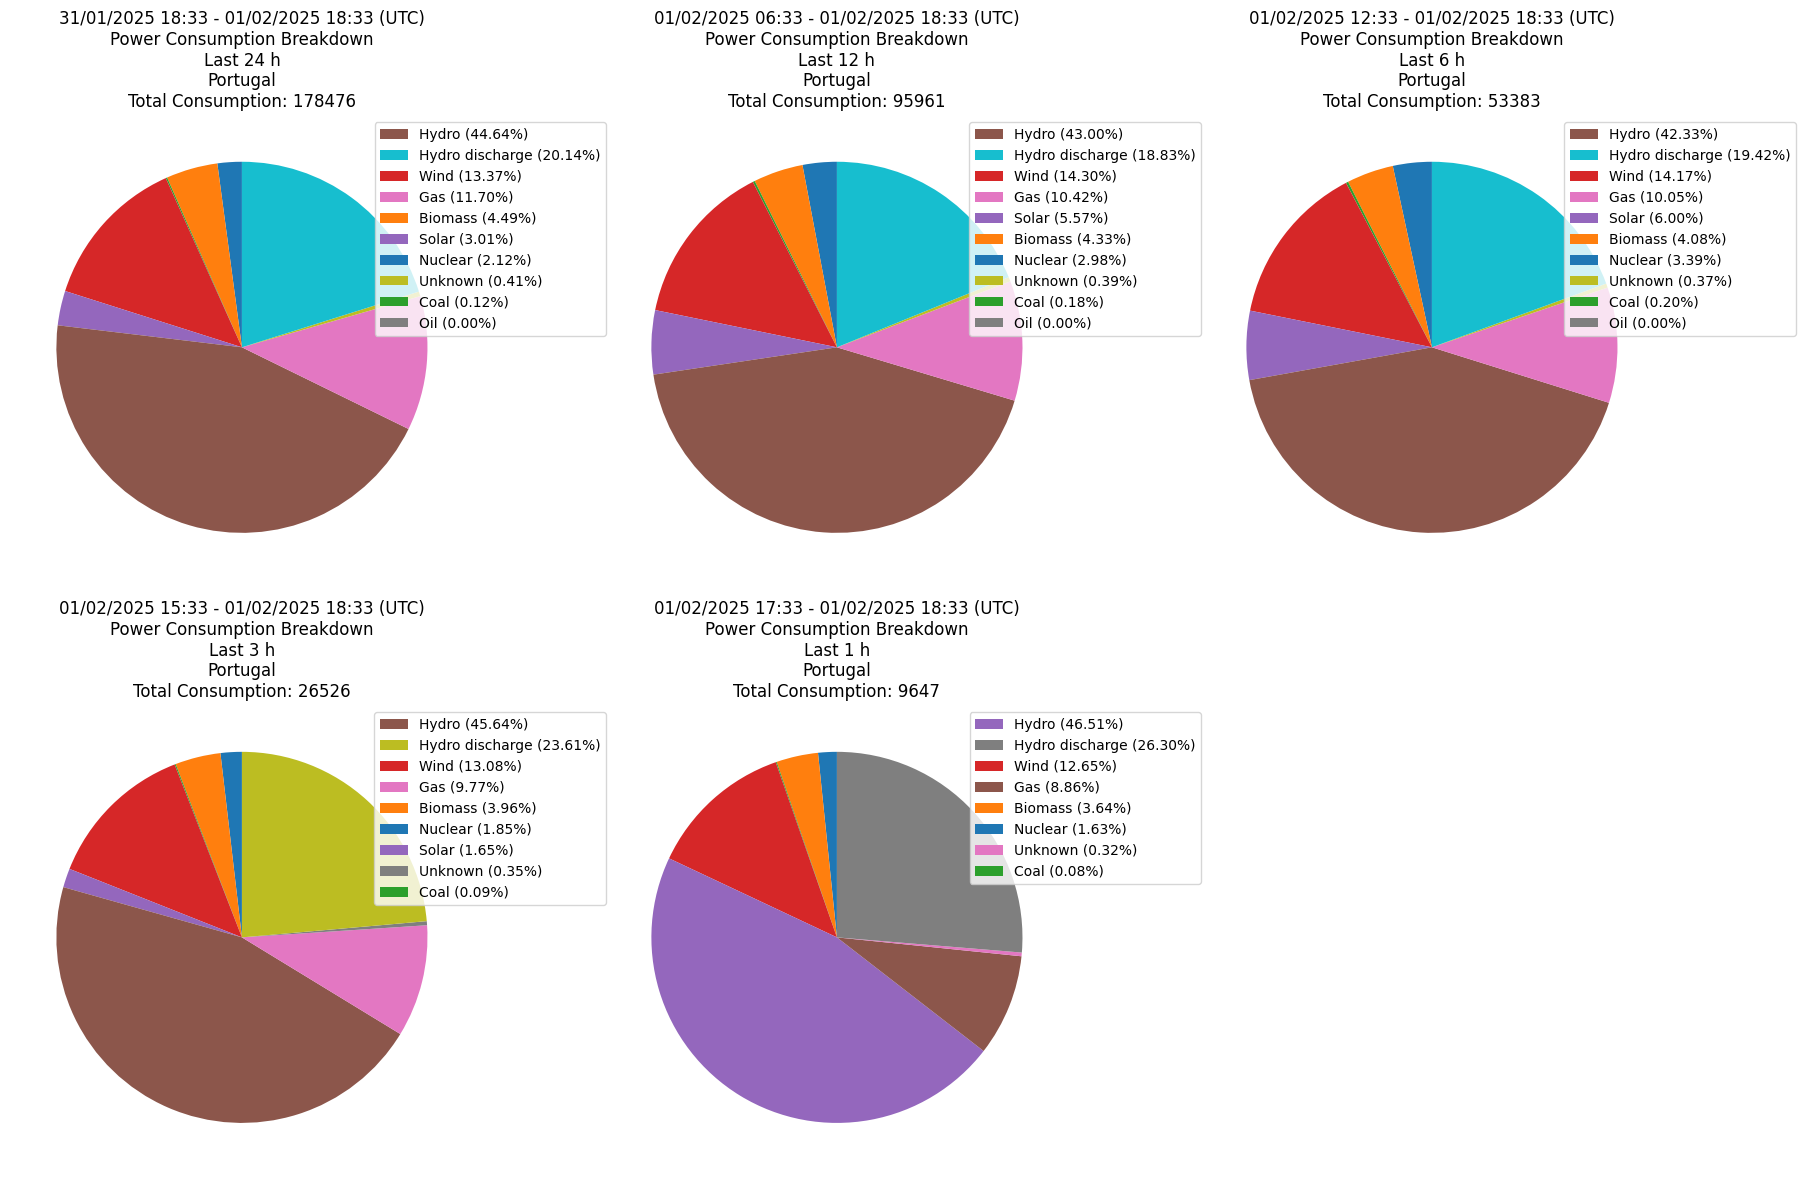

In [13]:
# Define os intervalos desejados (em horas)
time_frames = [24, 12, 6, 3, 1]
now = datetime.now(timezone.utc)

# Agrega os dados para cada intervalo e mantém apenas os que possuem consumo total > 0
valid_data = []
for horas in time_frames:
    consumption_breakdown_total, consumption_total_sum, limite = aggregate_consumption(historico, horas, now)
    if consumption_total_sum > 0:
        valid_data.append((horas, consumption_breakdown_total, consumption_total_sum, limite))

if not valid_data:
    print("Nenhum dado de consumo disponível para os intervalos especificados.")
else:
    # Cria os subplots de acordo com o número de intervalos válidos
    n_valid = len(valid_data)
    n_cols = min(3, n_valid)
    n_rows = ceil(n_valid / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    # Se houver somente um subplot, encapsula em uma lista
    if n_valid == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Para cada intervalo válido, gera o gráfico de pizza
    for i, (horas, consumption_breakdown_total, consumption_total_sum, limite) in enumerate(valid_data):
        labels = []
        valores = []
        # Prepara os dados: ignora itens com valor zero e trata valores negativos como zero
        for key, total in consumption_breakdown_total.items():
            total = max(total, 0)
            if total != 0:
                labels.append(format_label(key))
                valores.append(total)
        soma_total = sum(valores)
        # Cria o gráfico de pizza sem rótulos internos
        wedges, _ = axes[i].pie(valores, startangle=90)

        # Combina os itens (label, valor, wedge) e ordena em ordem decrescente pelo valor
        items = list(zip(labels, valores, wedges))
        items_sorted = sorted(items, key=lambda x: x[1], reverse=True)
        labels_sorted = [f"{lab} ({(val/soma_total*100):.2f}%)" for lab, val, _ in items_sorted]
        wedges_sorted = [w for _, _, w in items_sorted]

        # Formata a string do time frame para o título
        timeframe_str = f"{limite.strftime('%d/%m/%Y %H:%M')} - {now.strftime('%d/%m/%Y %H:%M')} (UTC)"
        axes[i].set_title(
            f"{timeframe_str}\nPower Consumption Breakdown\nLast {horas} h\nPortugal\nTotal Consumption: {consumption_total_sum}"
        )
        axes[i].legend(wedges_sorted, labels_sorted,
                       loc="upper right", bbox_to_anchor=(1.3, 1))

    # Desativa os subplots extras, se houver
    for j in range(len(valid_data), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()